In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
import scipy.sparse as sp
import scipy
import numpy as np

In [3]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [4]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = -L
config['domain']['maxExtent'] =  L
config['simulation'] = {'correctArea': True}

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['plot']['export'] = True
config['kernel'] = {'name': 'Wendland4'}
# config['kernel']['targetNeighbors'] = 100
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['integration']['scheme'] = 'symplecticEuler'
config['integration']['scheme'] = 'semiImplicitEuler'

# print(config['kernel'])

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


$\alpha = 0.009433431170699188$ is very low, consider increasing the value (should be > 0.01)
Re = 2000.0, $\nu_{sph} = 0.002$, $\alpha = 0.009433431170699188$


In [5]:

from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions


In [6]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

# particleState, mask = sampleParticles(config, sdfs = [])
particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions, randomizeParticles = False)

priorState = None
particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()


In [7]:
from diffSPH.v2.simulationSchemes.dfsph import simulationStep
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.neighborhood import searchNeighbors

from diffSPH.v2.sampling import generateInitialConditions

initialState = generateInitialConditions(particleState, config)
# initialState = {
#     'fluid': particleState,
#     'time': 0.0,
#     'timestep': 0,
#     'dt': torch.tensor(5e-4, device = config['compute']['device']),
# }

initialState['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * initialState['fluid']['positions'][:,0]) * torch.sin(k * initialState['fluid']['positions'][:,1])
initialState['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * initialState['fluid']['positions'][:,0]) * torch.cos(k * initialState['fluid']['positions'][:,1])


perennialState = copy.deepcopy(initialState)
config['dfsph']['maxIters'] = 512
config['dfsph']['errorThreshold'] = 5e-4
config['dfsph']['omega'] = 0.33

config['timestep']['dt'] = 1e-3
perennialState['dt'] = 1e-3

priorState = None
perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
perennialState['time'] += perennialState['dt']

searchNeighbors(perennialState, config)
div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

In [9]:
from diffSPH.v2.simulationSchemes.dfsph import callModule, computeDensity, computeGravity, computeViscosity, sphOperationStates, scatter_sum
solverState = copy.deepcopy(initialState)


In [10]:

solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10

In [11]:
searchNeighbors(solverState, config)
solverState['dt'] = 0.01
config['timestep']['dt'] = 0.01

solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')

In [12]:
# solverState['fluid']['advection'] = torch.zeros_like(solverState['fluid']['gravityAccel'])

solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']

In [13]:
def computeAdvectionDivergence(stateA, stateB, neighborhood, simConfig):
    with record_function("[SPH] - Fluid Divergence ($nabla cdot \\bar{v}$)"):
        divergence = sphOperationStates(stateA, stateB, (stateA['advectionVelocities'], stateB['advectionVelocities']), neighborhood=neighborhood, operation='divergence')
        return divergence
    

solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


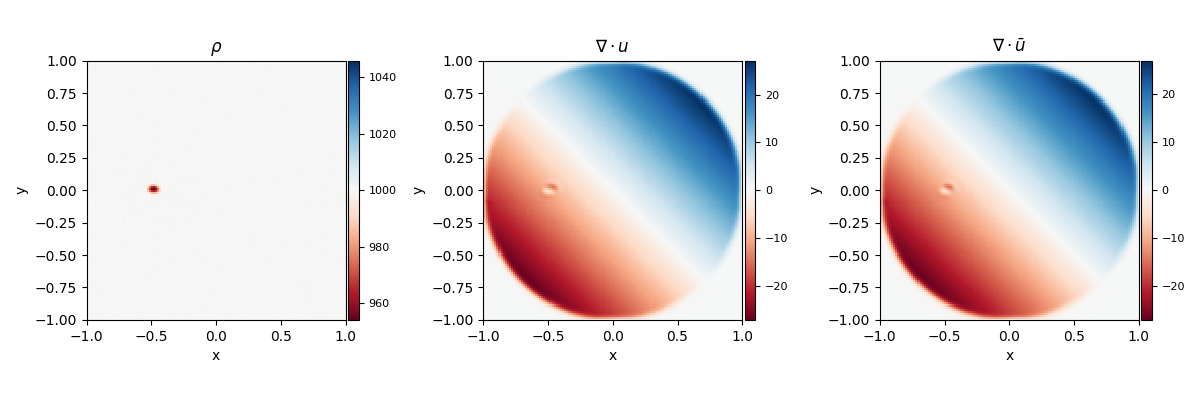

In [14]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

# xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                       'velocities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

# velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = '|Velocity|', plotBoth = False, which = 'fluid', midPoint = 0)

# xVelPlot = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, quantity =
#                                       'advectionVelocities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = 'x-Advection', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# yVelPlot = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, quantity = 
#                                       'advectionVelocities',
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'y-Advection', plotBoth = False, which = 'fluid', midPoint = 0)

# velPlot = visualizeParticleQuantity(fig, axis[1,2], config, visualizationState, quantity = 
#                                       'advectionVelocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = '|Advection|', plotBoth = False, which = 'fluid', midPoint = 0)

xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'densities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$\\rho$', which = 'fluid', plotBoth = False, midPoint = 1000, streamLines = False)
yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocityDivergence',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u$', plotBoth = False, which = 'fluid', midPoint = 0)

velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'advectionDivergence',
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot \\bar u$', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



In [15]:
# def solveISPH(stateA, stateB, config, neighborhood):
#     # stateA = solverState['fluid']
#     # stateB = solverState['fluid']
#     # neighborhood = stateA['neighborhood']

#     i,j = neighborhood['indices']
#     rij = neighborhood['distances']
#     hij = neighborhood['supports']
#     xij = neighborhood['vectors']
#     gradKernels = neighborhood['gradients']
#     pA = stateA['pressures']
#     pB = stateB['pressures']

#     quotient = (rij * hij + 1e-7 * hij)
#     kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
#     kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij

#     Aij = pA[i] - pB[j]
#     massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])
#     dimTerm = config['domain']['dim'] * 2 + 2

#     laplacianTerm = dimTerm * massTerm * kernelApproximation

#     aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

#     mask = i == j

#     A = laplacianTerm
#     A[mask] = aii

#     B = -solverState['fluid']['advectionDivergence'] / solverState['dt']

#     A = (laplacianTerm, (i,j), stateA['numParticles'])

#     p, iters, convergence1 = bicgstab(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence2 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence3 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence4 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence5 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)

#     return p, iters, convergence1 #+ convergence2# + convergence3 + convergence4 + convergence5

In [16]:
# p, iters, convergence, residuals = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

In [17]:
# fig,axis = plt.subplots(1,1)

# axis.semilogy([c.detach().cpu().numpy() for c in convergence], marker='o')

In [18]:
# from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
# from diffSPH.v2.plotting import exportPlot, postProcessPlot

# from diffSPH.v2.simulationSchemes.dfsph import callModule, computeDensity, computeGravity, computeViscosity, sphOperationStates, scatter_sum
# solverState = copy.deepcopy(initialState)

# # solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# # solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)

# searchNeighbors(solverState, config)
# solverState['dt'] = 0.01
# config['timestep']['dt'] = 0.01

# fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)


# visualizationState = prepVisualizationState(solverState, config, grid = True)
# # plotRegions(regions, axis[0,0])
# # plotRegions(regions, axis[0,1])

# s = 0.25

# xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                       'densities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 1000, streamLines = False)
# velPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = False, operation = None, title = '$u^{t}$', plotBoth = False, which = 'fluid', midPoint = 0)
# velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
#                                       'velocityDivergence' ,
#                                       mapping = 'L2', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u^{t+1}$', plotBoth = False, which = 'fluid', midPoint = 0)



# fig.tight_layout()

# # simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# # 



In [19]:
solverState = copy.deepcopy(initialState)

In [21]:

# from torch.profiler import profile, record_function, ProfilerActivity
# @torch.jit.script
# def cg_sparse(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], b, x0:Optional[torch.Tensor]=None, tol :float = 1e-5, rtol :float =1e-5, atol :float =0., maxiter: Optional[int]=None, M: Optional[Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int]]=None):
#     # with record_function("cg"):
    
#     if M is None:
#         M = make_id(A)
#     x = x0.clone() if x0 is not None else torch.zeros_like(b)
#     bnrm2 = torch.linalg.norm(b)

#     atol, _ = _get_atol_rtol('cg', bnrm2, atol, rtol)

#     convergence = []

#     if bnrm2 == 0:
#         return b, 0, convergence

#     n = len(b)

#     if maxiter is None:
#         maxiter = n*10

#     dotprod = torch.dot

#     # matvec = A.matvec
#     # psolve = M.matvec
#     r = b - matvec_sparse_coo(A, x) if x.any() else b.clone()

#     # Dummy value to initialize var, silences warnings
#     rho_prev = torch.zeros_like(b)
#     p = torch.zeros_like(b)

#     for iteration in range(maxiter):
#         if torch.linalg.norm(r) < atol:  # Are we done?
#             return x, iteration, convergence
#         # with record_function("cg_iter"):
#         z = matvec_sparse_coo(M, r)
#         rho_cur = torch.dot(r, z)
#         if iteration > 0:
#             beta = rho_cur / (rho_prev + atol)
#             p *= beta
#             p += z
#         else:  # First spin
#             p = z.clone()
#             # p = torch.empty_like(r)
#             # p[:] = z[:]

#         q = matvec_sparse_coo(A, p)
#         alpha = rho_cur / (torch.dot(p, q) + atol)
#         x += alpha*p
#         r -= alpha*q
#         rho_prev = rho_cur

#         # if callback:
#             # callback(x)
#         convergence.append(torch.linalg.norm(matvec_sparse_coo(A, x) - b))

#     # else:  # for loop exhausted
#         # Return incomplete progress
#     return x, maxiter, convergence

In [22]:
# from diffSPH.v2.sparse import cg as cg_sparse

solverState = copy.deepcopy(initialState)

# solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10


# solverState['fluid']['velocities'][:,0] = torch.sin(2 * np.pi * solverState['fluid']['positions'][:,0])
# solverState['fluid']['velocities'][:,1] = 0

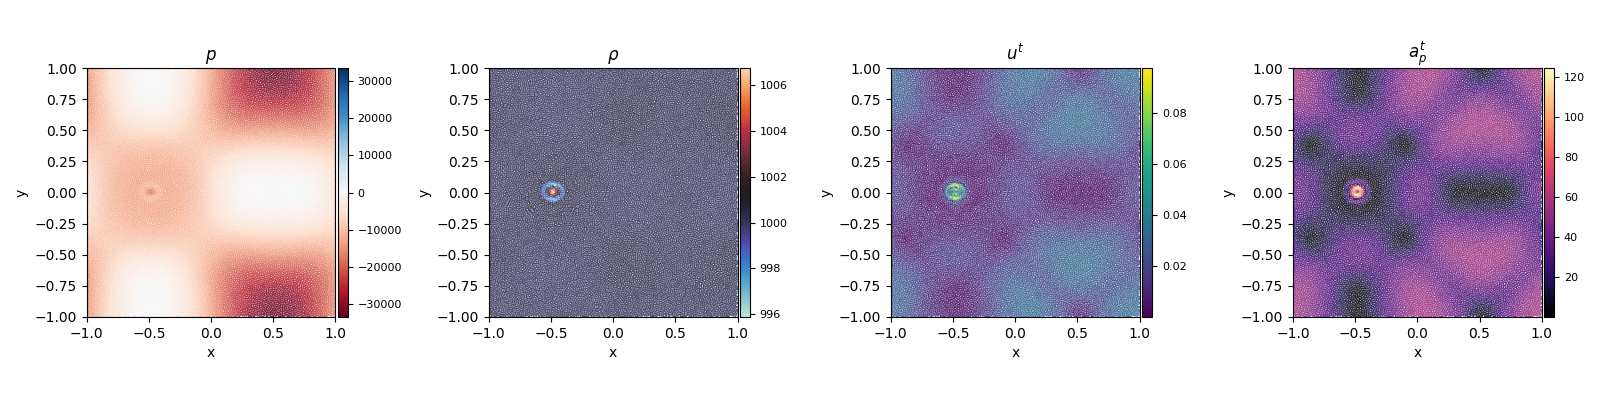

In [25]:
fig, axis = plt.subplots(1,4, figsize = (16,4), squeeze = False)


visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25
div = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


pressurePlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'pressure',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
rhoPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'densities',
                                      mapping = '.x', s = s, 
                          scaling = 'RdBu', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = '$\\rho$', plotBoth = False, which = 'fluid', midPoint = 1000)
velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'velocities' ,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = '$u^t$', plotBoth = False, which = 'fluid', midPoint = 0)

accelPlot = visualizeParticleQuantity(fig, axis[0,3], config, visualizationState, quantity = 
                                      a_p ,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'magma', streamLines = True, operation = None, title = '$a_p^t$', plotBoth = False, which = 'fluid', midPoint = 0)


fig.tight_layout()

In [57]:
solverState = copy.deepcopy(initialState)

# solverState['fluid']['velocities'][:,0] = torch.sin(2 * np.pi * solverState['fluid']['positions'][:,0])
# solverState['fluid']['velocities'][:,1] = 0

solverState['fluid']['velocities'][:,0] = 0
solverState['fluid']['velocities'][:,1] = 0

# solverState['fluid']['positions'] += torch.normal(0, 0.0001, size = solverState['fluid']['positions'].shape, device = solverState['fluid']['positions'].device)


solverState['dt'] = 1e-4
config['timestep']['dt'] = solverState['dt']

searchNeighbors(solverState, config)
convergence = []

# def callback(x):
    # convergence.append(torch.linalg.norm(matvec_sparse_coo(A_sp, x) - rhs))

def solveISPH(stateA, stateB, config, neighborhood):
    # stateA = solverState['fluid']
    # stateB = solverState['fluid']
    # neighborhood = stateA['neighborhood']

    i,j = neighborhood['indices']
    rij = neighborhood['distances']
    hij = neighborhood['supports']
    xij = neighborhood['vectors']
    gradKernels = neighborhood['gradients']
    # pA = stateA['pressures']
    # pB = stateB['pressures']

    quotient = (rij * hij + 1e-7 * hij)
    kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
    kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij

    # Aij = pA[i] - pB[j]
    massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])**2
    dimTerm = config['domain']['dim'] * 2 + 2
    dimTerm = 8
    # dimTerm = 4

    laplacianTerm =  dimTerm * massTerm * kernelApproximation

    aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

    mask = i == j

    A_ = laplacianTerm.clone()
    A_[mask] = -aii# + torch.normal(0, aii.abs().max() * 1e-3, aii.shape, device = aii.device)

    rho = stateA['densities']
    rhoStar = rho - rho * config['timestep']['dt'] * computeAdvectionDivergence(stateA, stateB, neighborhood, config)




    # print(f'Solver Input:')
    # print(f'Diagonal Elements: {aii.abs().max()} | {aii.abs().min()} | {aii.mean()}')
    # print(f'Non-Diagonal Elements: { laplacianTerm.abs().max()} | {laplacianTerm.abs().min()} | {laplacianTerm.mean()}')

    B = stateA['advectionDivergence'] / config['timestep']['dt'] #* rhoStar
    print(f'Divergence-Free Source Term: {B.abs().max()} | {B.abs().min()} | {B.mean()}')
    B -= B.mean()


    B = (config['fluid']['rho0'] - rhoStar) / config['timestep']['dt']**2 / config['fluid']['rho0']
    # B = (config['fluid']['rho0'] - rhoStar) / config['timestep']['dt']/ config['fluid']['rho0']
    print(f'Incompressible Source Term: {B.abs().max()} | {B.abs().min()} | {B.mean()}')
    # B -= B.mean()
    print(f'Current Density: {rho.abs().max()} | {rho.abs().min()} | {rho.mean()}')
    print(f'Advection Density: {rhoStar.abs().max()} | {rhoStar.abs().min()} | {rhoStar.mean()}')


    A = (-A_, (i,j), stateA['numParticles'])

    M = - 1/aii
    M_i = torch.arange(0, stateA['numParticles'], device = stateA['positions'].device)
    M_j = torch.arange(0, stateA['numParticles'], device = stateA['positions'].device)

    M_coo = (M, (M_i, M_j), stateA['numParticles'])

    # p, iters, convergence1, residuals = bicgstab(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512)
    # p, iters, convergence1, residuals = bicgstab(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512, M = M_coo)



    residuals = []
    A_sp = sp.coo_matrix((A[0].cpu().detach().to(torch.float64).numpy(), (A[1][0].cpu().detach().numpy(), A[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
    M_sp = sp.coo_matrix((M_coo[0].cpu().detach().to(torch.float64).numpy(), (M_coo[1][0].cpu().detach().numpy(), M_coo[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
    rhs = B.cpu().detach().to(torch.float64).numpy()


    M = scipy.sparse.linalg.spilu(A_sp, drop_tol=1e-3)
    lo = scipy.sparse.linalg.LinearOperator(A_sp.shape, lambda x: M.solve(x))

    # print(B.is_contiguous())
    # print(A[0].is_contiguous())

    # p, iters, convergence1  = cg_sparse(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 256)

    convergence = []
    # xs = []

    # p = scipy.sparse.linalg.bicgstab(A_sp, rhs, callback=lambda x: convergence.append([x.copy(), np.linalg.norm(A_sp.dot(x) - rhs)]), maxiter = 512, rtol = 1e-8, M = lo)
    p = scipy.sparse.linalg.cg(A_sp, rhs, callback=lambda x: convergence.append([x.copy(), np.linalg.norm(A_sp.dot(x) - rhs)]), maxiter = 512, rtol = 1e-4, M = lo)
    # display(A_sp)
    # display(rhs)
    # p = scipy.sparse.linalg.cg(A_sp, rhs)

    # print(p)
    p = torch.tensor(p[0], device = solverState['fluid']['positions'].device, dtype = torch.float32)


    # print([c.detach().cpu().numpy().item() for c in convergence])
    # print([r.shape for r in residuals])

    return p, None, convergence, residuals, A, B, M_coo #+ convergence2# + convergence3 + convergence4 + convergence5

for i in range(1):
    searchNeighbors(solverState, config)
    solverState['fluid']['pressure'] = torch.zeros_like(solverState['fluid']['densities'])
    solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
    solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
    solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')
    solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
    solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']
    solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
    solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


    solverState['fluid']['pressure'], iters, convergence, residuals, A, B, M = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

    a_p = sphOperationStates(solverState['fluid'], solverState['fluid'], (solverState['fluid']['pressure'], solverState['fluid']['pressure']), operation = 'gradient', gradientMode='summation', neighborhood= solverState['fluid']['neighborhood']) / solverState['fluid']['densities'].view(-1,1)

    finalVelocities = solverState['fluid']['advectionVelocities'] + a_p* solverState['dt']
    finalDivergence = sphOperationStates(solverState['fluid'], solverState['fluid'], (finalVelocities, finalVelocities), neighborhood=solverState['fluid']['neighborhood'], operation='divergence')


    stateA = solverState['fluid']
    stateB = solverState['fluid']
    neighborhood = stateA['neighborhood']

    initDiv = sphOperationStates(stateA, stateB, (stateA['velocities'], stateB['velocities']), neighborhood=neighborhood, operation='divergence')
    advDiv = sphOperationStates(stateA, stateB, (stateA['advectionVelocities'], stateB['advectionVelocities']), neighborhood=neighborhood, operation='divergence')
    accDiv = sphOperationStates(stateA, stateB, (solverState['dt'] * a_p, solverState['dt'] * a_p), neighborhood=neighborhood, operation='divergence')
    finalDiv = sphOperationStates(stateA, stateB, (finalVelocities, finalVelocities), neighborhood=neighborhood, operation='divergence')

    # print(solverState['dt'])
    solverState['fluid']['velocities'] = finalVelocities
    solverState['fluid']['positions'] += finalVelocities * solverState['dt']
    solverState['fluid']['velocities'][:,0] = 0
    solverState['fluid']['velocities'][:,1] = 0
    searchNeighbors(solverState, config)

    rho, _ = callModule(solverState, computeDensity, config, 'fluid')
    div = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)

    approx = (finalDiv - advDiv) - accDiv
    sol = finalDiv
    rel = finalDiv / advDiv

    searchNeighbors(solverState, config)
    visualizationState = prepVisualizationState(solverState, config, grid = True)
    # visualizationState = prepVisualizationState(perennialState, config)
    # div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
    
    # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
    updatePlot(pressurePlot, visualizationState, 'pressure')
    updatePlot(rhoPlot, visualizationState, 'densities')
    updatePlot(velPlot, visualizationState, 'velocities')
    updatePlot(accelPlot, visualizationState, a_p)
    

    # print(iters)
    print(f'Density Error: {solverState["fluid"]["densities"].min()} | {solverState["fluid"]["densities"].max()} | {solverState["fluid"]["densities"].mean()} -> {rho.min()} | {rho.max()} | {rho.mean()}')
    print(f'Initial Error: {initDiv.min()} | {initDiv.max()} | {initDiv.mean()}')
    # print(f'Approximation error: {approx.min()} | {approx.max()} | {approx.mean()}')
    print(f'Solution Error: {finalDiv.min()} | {finalDiv.max()} | {finalDiv.mean()}')
    # print(f'Relative Error: {rel.min()} | {rel.max()} | {rel.mean()}')


    print(f'Iteration: {i}, Divergence: {div.min()} | {div.max()}, Pressure: {solverState["fluid"]["pressure"].min()} | {solverState["fluid"]["pressure"].max()}, densities: {solverState["fluid"]["densities"].min()} | {solverState["fluid"]["densities"].max()}')

# print(f'Initial Divergence:   {initDiv.min()} | {initDiv.max()} | {initDiv.mean()} | {initDiv}')
# print(f'Advection Divergence: {advDiv.min()} | {advDiv.max()} | {advDiv.mean()} | {advDiv}')
# print(f'Accel Divergence:     {accDiv.min()} | {accDiv.max()} | {accDiv.mean()} | {accDiv}')
# print(f'Final Divergence:     {finalDiv.min()} | {finalDiv.max()} | {finalDiv.mean()} | {finalDiv}')
# print(f'Residual:             {(advDiv - accDiv).min()} | {(advDiv - accDiv).max()} | {(advDiv - accDiv).mean()} | {(advDiv - accDiv)}')

# ratio = initDiv / accDiv
# print(f'Ratio: {ratio.min()} | {ratio.max()} | {ratio.mean()} | {ratio}')

Divergence-Free Source Term: 0.0 | 0.0 | 0.0
Incompressible Source Term: 4595166.5 | 6.103516101837158 | -4152.3037109375
Current Density: 1000.34375 | 954.04833984375 | 1000.04150390625
Advection Density: 1000.34375 | 954.04833984375 | 1000.04150390625
Density Error: 954.04833984375 | 1000.34375 | 1000.04150390625 -> 268.97906494140625 | 2241.35546875 | 1148.2955322265625
Initial Error: 0.0 | 0.0 | 0.0
Solution Error: -245428.96875 | 520040.09375 | -7.956459045410156
Iteration: 0, Divergence: 0.0 | 0.0, Pressure: 84583178240.0 | 84593164288.0, densities: 954.04833984375 | 1000.34375


In [47]:
print(solverState['fluid']['pressure'].min(), solverState['fluid']['pressure'].max())

tensor(8.7979e+08, device='cuda:0') tensor(8.7988e+08, device='cuda:0')


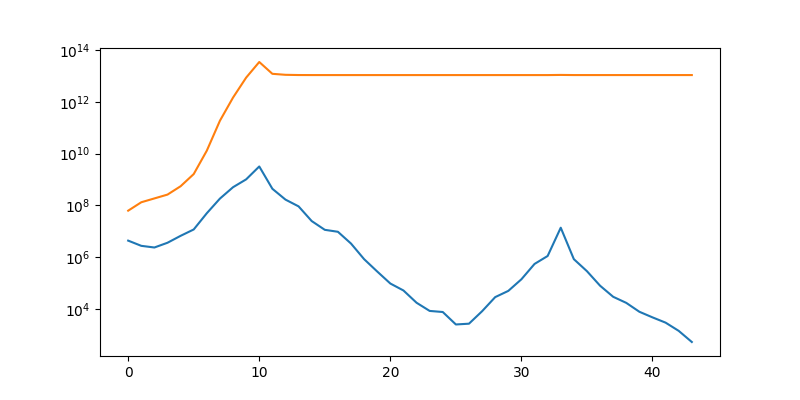

In [58]:
fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze = False)

# axis[0,0].semilogy([c.detach().cpu().numpy() for c in convergence])
axis[0,0].semilogy([c[1] for c in convergence])
axis[0,0].semilogy([np.linalg.norm(c[0]) for c in convergence])


In [939]:
A_sp = sp.coo_matrix((A[0].cpu().detach().numpy(), (A[1][0].cpu().detach().numpy(), A[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
M_sp = sp.coo_matrix((M[0].cpu().detach().numpy(), (M[1][0].cpu().detach().numpy(), M[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
rhs = B.cpu().detach().numpy()


display(A_sp)
display(M_sp)

<16384x16384 sparse matrix of type '<class 'numpy.float32'>'
	with 973230 stored elements in COOrdinate format>

<16384x16384 sparse matrix of type '<class 'numpy.float32'>'
	with 16384 stored elements in COOrdinate format>

In [940]:
B.shape

torch.Size([16384])

In [941]:
bicg = []
bicgstab = []

def callback(x):
    bicg.append(np.linalg.norm(A_sp.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.bicg(A_sp, rhs, callback=callback, maxiter = 512)

def callback(x):
    bicgstab.append(np.linalg.norm(A_sp.dot(x) - rhs))
sol2_nostab = scipy.sparse.linalg.bicgstab(A_sp, rhs, callback=callback, maxiter = 512)

# bicg_stab_no_prec = []
# bicg_stab_prec = []

# def callback(x):
#     bicg_stab_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

# sol2_nostab = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=callback, M=D)
# def callback(x):
#     bicg_stab_no_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

# sol2_nostab = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=callback)

# gmres = []
# # gmres_no_prec = []

# def callback(r):
#     gmres_prec.append(r)
# sol = scipy.sparse.linalg.gmres(A_sp, rhs, callback=callback, restart=50)

# def callback(r):
#     gmres_no_prec.append(r)
# sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=callback, restart=50)

In [942]:
    residuals = []
    A_sp = sp.coo_matrix((A[0].cpu().detach().numpy(), (A[1][0].cpu().detach().numpy(), A[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
    # M_sp = sp.coo_matrix((M[0].cpu().detach().numpy(), (M[1][0].cpu().detach().numpy(), M[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
    rhs = B.cpu().detach().numpy()
    # p, iters, convergence1  = cg_sparse(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 256)

    convergence = []

    p = scipy.sparse.linalg.cg(A_sp, rhs, callback=lambda x: convergence.append(np.linalg.norm(A_sp.dot(x) - rhs)), maxiter = 512)
    # display(A_sp)
    # display(rhs)
    # p = scipy.sparse.linalg.cg(A_sp, rhs)

In [943]:

cg = []
def callback(x):
    cg.append(np.linalg.norm(A_sp.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.cg(A_sp, rhs, callback=callback, maxiter = 512)

print(cg)

[34909.62, 33194.56, 65365.58, 101414.49, 80791.91, 45341.93, 29941.41, 26942.174, 31566.531, 39042.094, 38029.457, 29946.732, 24476.578, 23727.705, 25930.828, 27905.846, 27211.03, 25492.96, 25484.771, 26933.68, 27776.383, 27116.115, 26455.98, 27420.998, 29942.896, 31209.984, 29541.143, 26992.408, 26986.04, 30910.42, 37737.523, 44322.133, 47968.31, 50254.48, 54323.473, 61575.766, 71090.87, 82417.28, 96593.56, 116761.266, 138612.36, 153412.92, 164039.8, 166094.06, 151421.73, 154897.34, 167988.58, 179009.75, 188956.66, 193460.39, 199211.08, 196474.78, 184406.12, 175155.83, 174642.4, 196178.77, 227056.78, 252020.27, 259672.94, 250306.45, 255234.83, 286663.97, 309867.4, 315318.56, 349139.0, 394931.0, 458703.97, 542669.6, 610197.8, 696165.0, 772006.9, 880260.25, 1005510.2, 1163535.0, 1325164.9, 1523643.9, 1794962.1, 2116209.5, 2545276.2, 3068091.8, 3726899.0, 4614673.0, 5855398.0, 7723204.5, 10539275.0, 14949967.0, 22191272.0, 39589664.0, 123353880.0, 92614370.0, 363995800.0, 112619450.0, 1

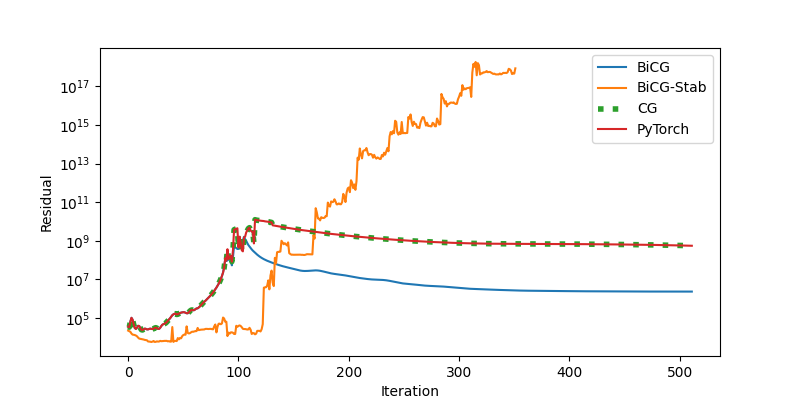

In [944]:
fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze = False)

# axis[0,0].semilogy([c.detach().cpu().numpy() for c in convergence])
axis[0,0].semilogy(bicg, label = 'BiCG')
axis[0,0].semilogy(bicgstab, label = 'BiCG-Stab')
# axis[0,0].semilogy(gmres, label = 'GMRES')
axis[0,0].semilogy(cg, label = 'CG', ls = ':', lw = 4)

# axis[0,0].semilogy([c.detach().cpu().numpy() for c in convergence], label = 'PyTorch')
axis[0,0].semilogy([c for c in convergence], label = 'PyTorch')


axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Residual')

axis[0,0].legend()



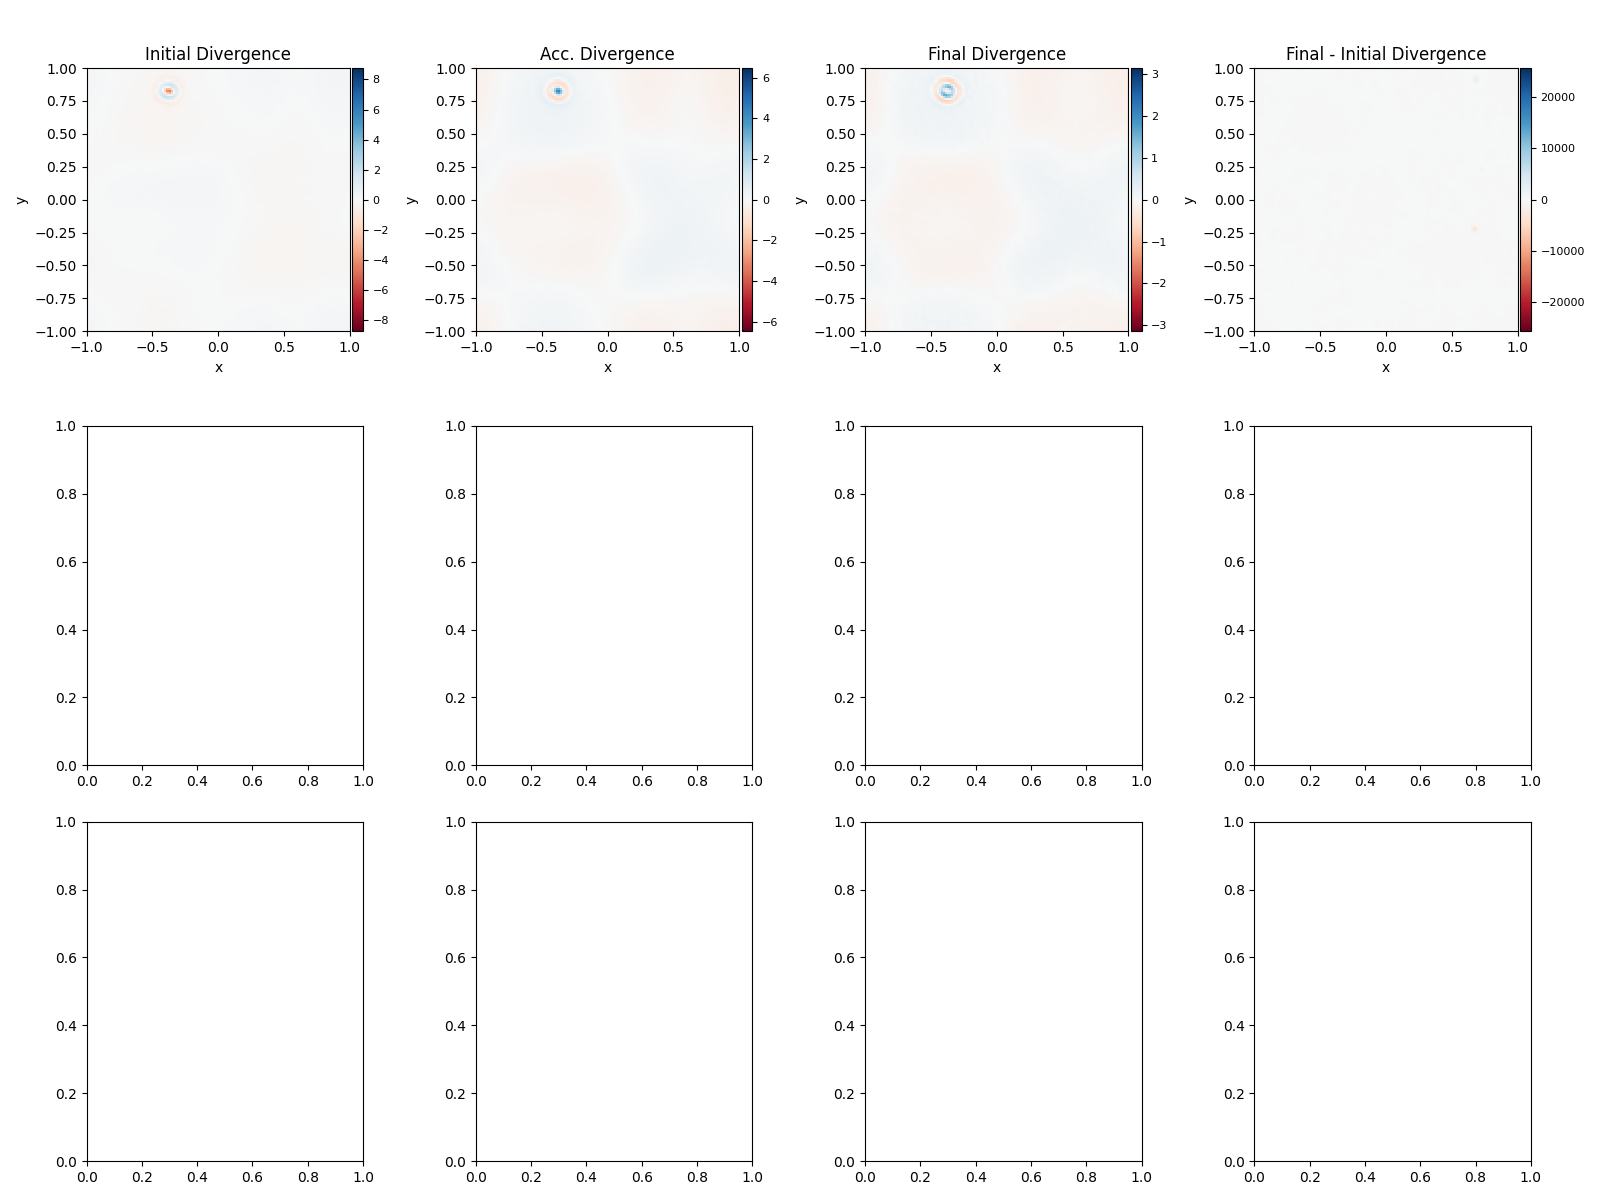

In [945]:
fig, axis = plt.subplots(3,4, figsize = (16,12), squeeze = False)
visualizationState = prepVisualizationState(solverState, config, grid = True)
b = solverState['fluid']['advectionDivergence'] / solverState['dt']
# residualPlot_00 = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                     b, mapping = '.x', s = s, 
#                         scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Iteration {i}', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# print(f'Iteration {i} mean residual: {residuals[i].mean()}, min: {residuals[i].min()}, max: {residuals[i].max()}')


for i, (ax, r) in enumerate(zip(axis.flatten()[4:], residuals if len(residuals) < 8 else residuals[-8:])):
    residualPlot_00 = visualizeParticleQuantity(fig, ax, config, visualizationState, quantity =
                                      r - b, mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'RdBu', title = f'Iteration {i}', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
    print(f'Iteration {i} mean residual: {(r-b).mean()}, min: {(r - b).min()}, max: {(r - b ).max()}')

residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[0], config, visualizationState, quantity =
                                    initDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Initial Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[1], config, visualizationState, quantity =
                                    accDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Acc. Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[2], config, visualizationState, quantity =
                                    finalDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Final Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[3], config, visualizationState, quantity =
                                    finalDiv/initDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Final - Initial Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)


fig.tight_layout()

In [946]:
finalDiv/accDiv

tensor([ 2.6700, -1.3211,  1.8736,  ...,  2.4875,  0.6518, -1.0003],
       device='cuda:0')

In [947]:
solverState = copy.deepcopy(initialState)

# solverState['fluid']['velocities'][:,0] = torch.sin(solverState['fluid']['positions'][:,1] * 2 * np.pi)
# solverState['fluid']['velocities'][:,1] = 0
solverState['fluid']['pressure'] = torch.zeros_like(solverState['fluid']['densities'])


In [948]:
solverState['fluid']['pressure']

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

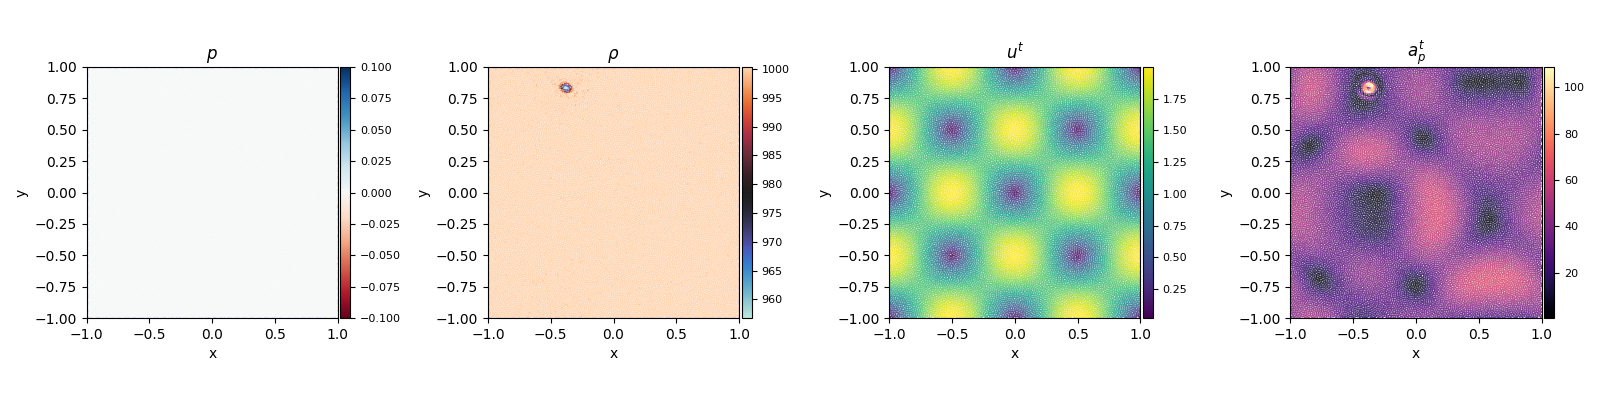

In [949]:
fig, axis = plt.subplots(1,4, figsize = (16,4), squeeze = False)


visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25
div = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


pressurePlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'pressure',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
rhoPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'densities',
                                      mapping = '.x', s = s, 
                          scaling = 'RdBu', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = '$\\rho$', plotBoth = False, which = 'fluid', midPoint = 1000)
velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'velocities' ,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = '$u^t$', plotBoth = False, which = 'fluid', midPoint = 0)

accelPlot = visualizeParticleQuantity(fig, axis[0,3], config, visualizationState, quantity = 
                                      a_p ,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'magma', streamLines = True, operation = None, title = '$a_p^t$', plotBoth = False, which = 'fluid', midPoint = 0)


fig.tight_layout()

In [950]:
# solverState = copy.deepcopy(initialState)

# solverState['fluid']['velocities'][:,0] = torch.sin(solverState['fluid']['positions'][:,1] * 2 * np.pi)
# solverState['fluid']['velocities'][:,1] = 0
# solverState['fluid']['pressure'] = torch.zeros_like(solverState['fluid']['densities'])


for i in tqdm(range(512)):
    solverState['time'] += perennialState['dt']
    solverState['timestep'] += 1

    searchNeighbors(solverState, config)

    solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
    solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
    solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')
    solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
    # solverState['fluid']['advection'][:,0] += torch.sin(2 * np.pi * solverState['fluid']['positions'][:,1]) * solverState['dt']

    
    solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']
    solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
    solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


    solverState['fluid']['pressure'], iters, convergence, residuals, A, B, M = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

    # solverState['fluid']['pressure'] = - solverState['fluid']['pressure']

    a_p = sphOperationStates(solverState['fluid'], solverState['fluid'], (solverState['fluid']['pressure'], solverState['fluid']['pressure']), operation = 'gradient', gradientMode='summation', neighborhood= solverState['fluid']['neighborhood']) / solverState['fluid']['densities'].view(-1,1)

    finalVelocities = solverState['fluid']['advectionVelocities'] + a_p* solverState['dt']
    finalDivergence = sphOperationStates(solverState['fluid'], solverState['fluid'], (finalVelocities, finalVelocities), neighborhood=solverState['fluid']['neighborhood'], operation='divergence')


    stateA = solverState['fluid']
    stateB = solverState['fluid']
    neighborhood = stateA['neighborhood']

    initDiv = sphOperationStates(stateA, stateB, (stateA['velocities'], stateB['velocities']), neighborhood=neighborhood, operation='divergence')
    advDiv = sphOperationStates(stateA, stateB, (stateA['advectionVelocities'], stateB['advectionVelocities']), neighborhood=neighborhood, operation='divergence')
    accDiv = sphOperationStates(stateA, stateB, (solverState['dt'] * a_p, solverState['dt'] * a_p), neighborhood=neighborhood, operation='divergence')
    finalDiv = sphOperationStates(stateA, stateB, (finalVelocities, finalVelocities), neighborhood=neighborhood, operation='divergence')


    solverState['fluid']['velocities'] = finalVelocities
    solverState['fluid']['positions'] += finalVelocities * solverState['dt']
    div = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)



    print(f'Iteration: {i}, Divergence: {div.min()} | {div.max()}, Pressure: {solverState["fluid"]["pressure"].min()} | {solverState["fluid"]["pressure"].max()}, densities: {solverState["fluid"]["densities"].min()} | {solverState["fluid"]["densities"].max()}')

    # print(f'Initial Divergence:   {initDiv.min()} | {initDiv.max()} | {initDiv.mean()} | {initDiv}')
    print(f'Advection Divergence: {advDiv.min()} | {advDiv.max()} | {advDiv.mean()} | {advDiv}')
    print(f'Accel Divergence:     {accDiv.min()} | {accDiv.max()} | {accDiv.mean()} | {accDiv}')
    # print(f'Final Divergence:     {finalDiv.min()} | {finalDiv.max()} | {finalDiv.mean()} | {finalDiv}')
    # print(f'Residual:             {(advDiv - accDiv).min()} | {(advDiv - accDiv).max()} | {(advDiv - accDiv).mean()} | {(advDiv - accDiv)}')

    if i % 8 == 0:
        searchNeighbors(solverState, config)
        visualizationState = prepVisualizationState(solverState, config, grid = True)
        # visualizationState = prepVisualizationState(perennialState, config)
        # div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(pressurePlot, visualizationState, 'pressure')
        updatePlot(rhoPlot, visualizationState, 'densities')
        updatePlot(velPlot, visualizationState, 'velocities')
        updatePlot(accelPlot, visualizationState, a_p)
        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        # exportPlot(perennialState, config, fig)

  0%|          | 0/512 [00:00<?, ?it/s]

Divergence-Free Source Term: 1939.172607421875 | 0.009354367852210999 | -0.00016957521438598633
Incompressible Source Term: 42532.65234375 | 0.0 | -41.89962387084961
Current Density: 1000.38427734375 | 957.4383544921875 | 1000.0418701171875
Advection Density: 1001.05712890625 | 957.4673461914062 | 1000.0419311523438
Iteration: 0, Divergence: -10.941309928894043 | 0.719178318977356, Pressure: -15133.8291015625 | 74776.2734375, densities: 957.4383544921875 | 1000.38427734375
Advection Divergence: -1.9391757249832153 | 1.7736421823501587 | -1.1041993275284767e-07 | tensor([-0.1419, -0.0709,  0.0652,  ..., -0.1355, -0.0930,  0.1060],
       device='cuda:0')
Accel Divergence:     -10.069177627563477 | 0.07891582697629929 | 0.00026554526994004846 | tensor([ 0.0204,  0.0067, -0.0097,  ...,  0.0238,  0.0588,  0.0426],
       device='cuda:0')
Divergence-Free Source Term: 10900.8173828125 | 0.013505219481885433 | 0.21497392654418945
Incompressible Source Term: 27768.189453125 | 0.061035159975290

KeyboardInterrupt: 

  0%|          | 0/256 [00:00<?, ?it/s]

[0.1583489626646042, 0.07733796536922455, 0.052843622863292694, 0.04024842008948326, 0.03235901892185211, 0.026884004473686218, 0.02276621013879776, 0.01958506740629673, 0.017193052917718887, 0.01533567439764738, 0.013764981180429459, 0.012241830118000507, 0.010959604755043983, 0.009750910103321075, 0.008801978081464767, 0.008092448115348816, 0.007503774017095566, 0.00699051795527339, 0.006362928077578545, 0.005470598116517067, 0.005397814325988293, 0.004585231188684702, 0.004335539415478706, 0.003939945250749588, 0.026406535878777504, 0.003462046617642045, 0.003168828086927533, 0.003111028578132391, 0.0030905224848538637, 0.002684845821931958, 0.0024267639964818954, 0.0025631713215261698, 0.0024949756916612387, 0.0018495729891583323, 0.0017644591862335801, 0.0011260759783908725, 0.0014113852521404624, 0.0013523445231840014, 0.0010464346269145608, 0.001120393630117178, 0.0010509752901270986, 0.0009478653664700687, 0.0008552554063498974, 0.0008296513697132468, 0.0007834323332644999, 0.0

RuntimeError: shape mismatch: value tensor of shape [16384] cannot be broadcast to indexing result of shape [3903]

In [ ]:
priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # dx, _ = solveShifting(perennialState, config)
    # numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    # perennialState['fluid']['shiftAmount'] = dx
    # perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    # if config['compute']['checkNaN']:
    #     checkNaN(perennialState['fluid']['positions'], 'positions')
    #     checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    perennialState['time'] += perennialState['dt']
    perennialState['timestep'] += 1
    # print(f'Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}')

    if i % 128 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'pressureIncompressible')
        updatePlot(l2Plot, visualizationState, div)
        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)


        
        E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
        E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
        nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
        Re = u_mag * 2 / nu_total


        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')
        # fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



In [ ]:
def computeFinalDivergence(stateA, stateB, neighborhood, simConfig):
    with record_function("[SPH] - Fluid Divergence ($nabla cdot \\bar{v}$)"):
        divergence = sphOperationStates(stateA, stateB, (stateA['finalVelocities'], stateB['finalVelocities']), neighborhood=neighborhood, operation='divergence')
        return divergence
    


print(f'Initial Divergence: {solverState["fluid"]["velocityDivergence"].abs().max()}, mean: {solverState["fluid"]["velocityDivergence"].abs().mean()}')
# div = computeFinalDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)

Initial Divergence: 1.1614457368850708, mean: 0.46628260612487793


In [ ]:
from diffSPH.v2.simulationSchemes.dfsph import callModule, computeDensity, computeGravity, computeViscosity, sphOperationStates, scatter_sum
solverState = copy.deepcopy(initialState)

# solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
searchNeighbors(solverState, config)
solverState['dt'] = 0.01
config['timestep']['dt'] = 0.01

for i in range(32):
    
    solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
    solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
    solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')
    solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
    solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']
    solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
    solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


    p, iters, convergence = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

    a_p = -sphOperationStates(solverState['fluid'], solverState['fluid'], (p, p), operation = 'gradient', gradientMode='symmetric', neighborhood= solverState['fluid']['neighborhood']) / solverState['fluid']['densities'].view(-1,1)
    finalVelocities = solverState['fluid']['advectionVelocities'] + a_p * solverState['dt']
    finalDivergence = sphOperationStates(solverState['fluid'], solverState['fluid'], (finalVelocities, finalVelocities), neighborhood=solverState['fluid']['neighborhood'], operation='divergence')

    solverState['fluid']['velocities'] = finalVelocities


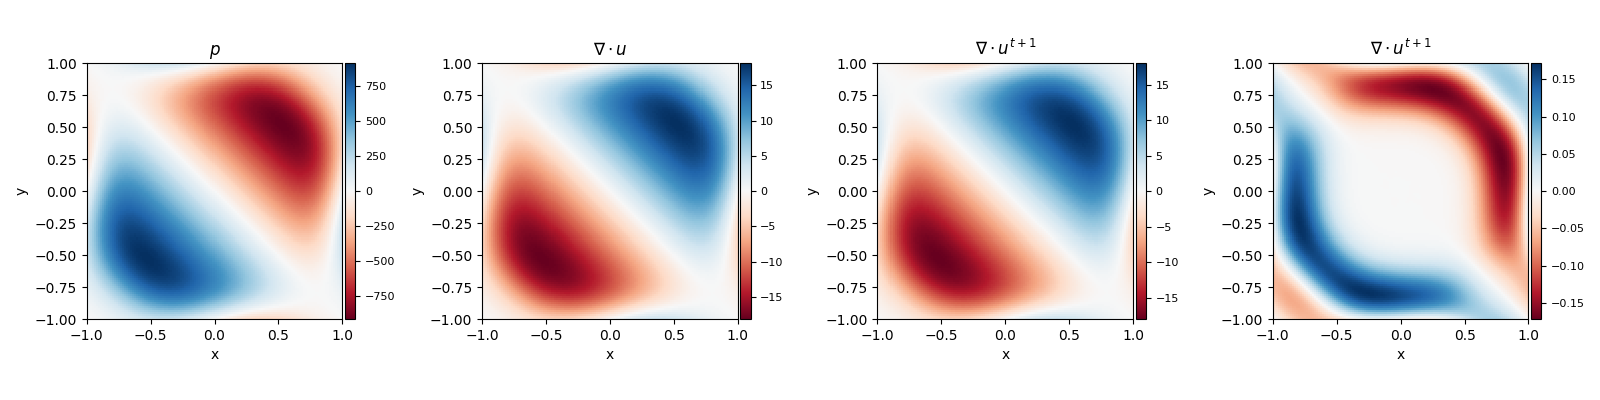

In [ ]:
solverState['pressures'] = torch.zeros_like(solverState['fluid']['densities'])

In [ ]:
stateA = solverState['fluid']
stateB = solverState['fluid']
neighborhood = stateA['neighborhood']

i,j = neighborhood['indices']
rij = neighborhood['distances']
hij = neighborhood['supports']
xij = neighborhood['vectors']
gradKernels = neighborhood['gradients']
pA = stateA['pressures']
pB = stateB['pressures']

quotient = (rij * hij + 1e-7 * hij)
kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij

In [ ]:
Aij = pA[i] - pB[j]
massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])
dimTerm = config['domain']['dim'] * 2 + 2

laplacianTerm = dimTerm * massTerm * kernelApproximation

aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

mask = i == j

A = laplacianTerm
A[mask] = aii

B = solverState['fluid']['advectionDivergence'] / solverState['dt']**3

A = (laplacianTerm, (i,j), stateA['numParticles'])

In [ ]:
p, iters, convergence = bicg(A, -B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512)

print(iters, convergence)

p, iters, convergence = bicg(A, -B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)

Iter 0, Residual: 1567563648.0
Iter 1, Residual: 32864440.0
Iter 2, Residual: 5100007.5
Iter 3, Residual: 977547.5625
Iter 4, Residual: 199048.65625
Iter 5, Residual: 41491.64453125
Iter 6, Residual: 8738.3974609375
Iter 7, Residual: 1852.215576171875
Iter 8, Residual: 394.5318298339844
Iter 9, Residual: 84.29361724853516
Iter 10, Residual: 18.063350677490234
Iter 11, Residual: 3.887315511703491
Iter 12, Residual: 0.8368783593177795
Iter 13, Residual: 0.18033309280872345
14 [tensor(32864442., device='cuda:0'), tensor(5100006., device='cuda:0'), tensor(977554.1875, device='cuda:0'), tensor(199046.0469, device='cuda:0'), tensor(41495.4102, device='cuda:0'), tensor(8747.5312, device='cuda:0'), tensor(1882.0022, device='cuda:0'), tensor(541.1484, device='cuda:0'), tensor(366.3199, device='cuda:0'), tensor(358.9917, device='cuda:0'), tensor(358.6536, device='cuda:0'), tensor(359.9285, device='cuda:0'), tensor(361.6763, device='cuda:0'), tensor(361.5761, device='cuda:0')]
Iter 0, Residual: 3

In [ ]:

# p, convergence, iters, residual = BiCGStab_wJacobi(A, B, torch.zeros_like(B), i, j)

# print(f'Iterations: {iters}, Residual: {residual}, {convergence}')
# print(f'p: {p}, min: {p.min()}, max: {p.max()}, mean: {p.mean()}')

In [ ]:
a_p = -sphOperationStates(stateA, stateB, (p, p), operation = 'gradient', gradientMode='symmetric', neighborhood= neighborhood) / stateA['densities'].view(-1,1)
finalVelocities = stateA['advectionVelocities'] + a_p * solverState['dt']
finalDivergence = sphOperationStates(stateA, stateB, (finalVelocities, finalVelocities), neighborhood=neighborhood, operation='divergence')



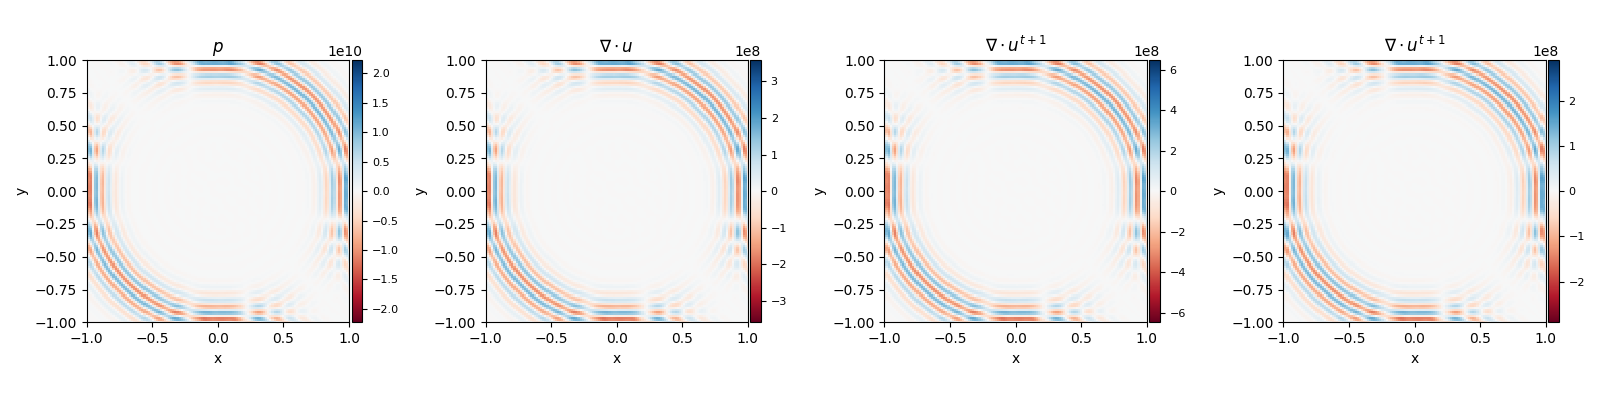

In [ ]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,4, figsize = (16,4), squeeze = False)

visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      p,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocityDivergence',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u$', plotBoth = False, which = 'fluid', midPoint = 0)

velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      finalDivergence,
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u^{t+1}$', plotBoth = False, which = 'fluid', midPoint = 0)
velPlot = visualizeParticleQuantity(fig, axis[0,3], config, visualizationState, quantity = 
                                      finalDivergence - solverState['fluid']['velocityDivergence'],
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u^{t+1}$', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



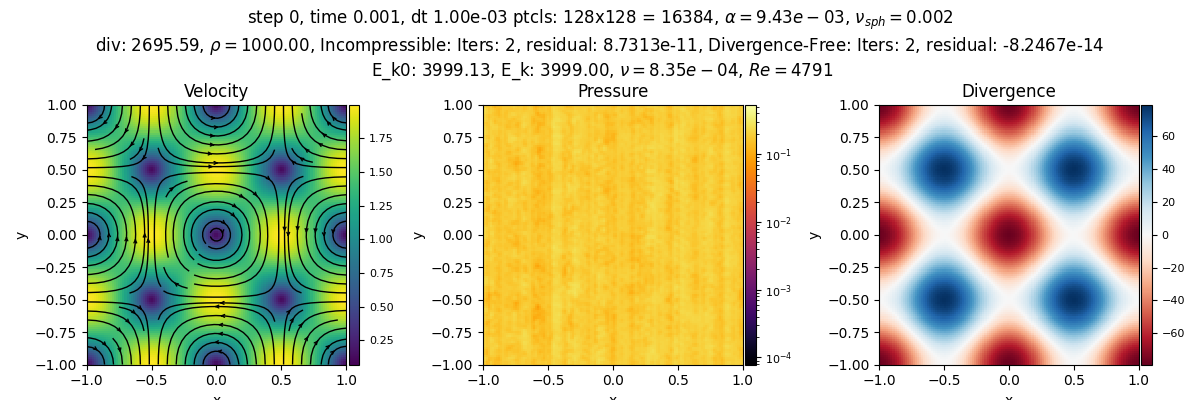

In [ ]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = True)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'pressureIncompressible',
                                      mapping = '.y', s = s, 
                          scaling = 'log', gridVisualization=True, cmap = 'inferno', streamLines = False, operation = None, title = 'Pressure', plotBoth = False, which = 'fluid', midPoint = 1000)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      div,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'Divergence', plotBoth = False, which = 'fluid', midPoint = 0)

E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(priorState["fluid"]["convergence_density"])}, residual: {priorState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(priorState["fluid"]["convergence_divergence"])}, residual: {priorState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')

fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



In [ ]:
priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # dx, _ = solveShifting(perennialState, config)
    # numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    # perennialState['fluid']['shiftAmount'] = dx
    # perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    # if config['compute']['checkNaN']:
    #     checkNaN(perennialState['fluid']['positions'], 'positions')
    #     checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    perennialState['time'] += perennialState['dt']
    perennialState['timestep'] += 1
    # print(f'Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}')

    if i % 128 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'pressureIncompressible')
        updatePlot(l2Plot, visualizationState, div)
        
        
        E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
        E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
        nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
        Re = u_mag * 2 / nu_total


        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')
        # fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



  0%|          | 0/4096 [00:00<?, ?it/s]

In [ ]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_07_04-11_20_46/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_07_04-11_20_46.gif'], returncode=0)